## Sparse Identification of Nonlinear Dynamics (SINDy)

O SINDy é um algorítmo para identificação de dinâmicas não lineares que combina possíveis estruturas, baseado no fato de que muitos sistemas dinâmicos tem o formato:

$\frac{d }{d t}x = f(x) = \dot{x}$

sendo f uma dinâmica com poucos termos não lineares, como a equação de Lorenz e as equações de Navier-Stokes (veremos a frente).

Vamos escrever essa equação diferencial de maneira matricial com $X$ representando os estados de um sistema (dados) ao longo do tempo $t$ e $\dot{X}$ a matriz de derivadas de $X$:

$X = [x(t_1) \ x(t_2) \ x(t_3) \ ... \ x(t_m)]^{T}$


$\dot{X} = [\dot{x}(t_1) \ \dot{x}(t_2) \ \dot{x}(t_3) \ ... \ \dot{x}(t_m)]^{T}$

Em geral não podemos assumir que temos os dados relativos a derivada de um sistema dinâmico, mas podemos calcula-lo de maneira numérica.

Criaremos a partir de $X$ uma biblioteca de funções $\Theta(X)$:

$\Theta(X) = [1 \ X \ X^2 \ ... \ X^d \ ... \ sin(X) \ ...]$

sendo $X^d$ a matriz com todos as possíveis comnbinações de grau $d$ das variáveis de $X$

Essa biblioteca pode conter qualquer tipo de função não linear, nesse caso a escolha depende da dinâmica a ser modelada. Para utilizar esse método, é importante que se tenha uma ideia de como se comportam as variáveis do sistema para fazer uma boa escolha, coerente com os dados.


$X_{m \times n} =$

$$
\begin{bmatrix}
x(t_1) \\ x(t_2) \\ x(t_3) \\ ... \\ x(t_m)
\end{bmatrix} =
\begin{bmatrix}
x_1(t_1) & x_2(t_1) & ... & x_{n-1}(t_1) & x_n(t_1) \\
x_1(t_2) & x_2(t_2) & ... & x_{n-1}(t_2) & x_n(t_2) \\
x_1(t_3) & x_2(t_3) & ... & x_{n-1}(t_3) & x_n(t_3) \\
... & ... & ... & ... & ... & \\
x_1(t_m) & x_2(t_m) & ... & x_{n-1}(t_m) & x_n(t_m) \\
\end{bmatrix}
$$

supondo $n = 2$

$ x_1 = x $

$ x_2 = y $

$\Theta_{m \times p}(X) =$

\begin{bmatrix}
1 & X_1 & X_2  & X_1^2 & X_2^2 & X_1X_2 &... & sin(X_1) & sin(X_2) & ...\\
1 & x(t_1) & y(t_1) & x^2(t_1) & y^2(t_1) & x(t_1)y(t_1) &... & sin(x(t_1)) & sin(y(t_1)) & ...\\
1 & x(t_2) & y(t_2) & x^2(t_2) & y^2(t_2) & x(t_2)y(t_2) &... & sin(x(t_2)) & sin(y(t_2)) & ...\\\\
... & ... & ... & ... & ... & ... & ... & ... & ... & ... \\
1 & x(t_m) & y(t_m)  & x^2(t_m) & y^2(t_m) & x(t_m)y(t_m) &... & sin(x(t_m)) & sin(y(t_m)) & ...\\
\end{bmatrix}


Nosso objetivo é encontrar uma matriz de coeficientes $\Xi$ que aproxime a dinâmica de $X$.Podemos escrever:

$\dot{X} = \Theta(X)\Xi$


$ \Xi_{p × n} = $
\begin{bmatrix}
\xi_1 & \xi_2 & ... & \xi_n \\
a_{11} & a_{21} & ... & a_{n1} \\
a_{12} & a_{22} & ... & a_{n2} \\
a_{13} & a_{23} & ... & a_{n3} \\
... & ... & ... & ... \\
a_{1p} & a_{2p} & ... & a_{np}\\
 \end{bmatrix}

A minimização que estamos interessados será:

$\underset{\Xi }{argmin} \left \| \dot{X} -\Theta(X)\Xi \right \|_2 + \lambda \left\| \Xi \right\|$

Sendo $\lambda$ o coeficiente de "esparsidade"(?) que usaremos para tornar nossa matriz $\Xi$ esparsa. Podemos usar norma 1 ou 0 (sendo "norma 0" o número de termos não nulos na matriz, sabendo que a "norma 0" não existe)


Analisando cada coluna de $\Xi$ temos:



$ \xi_k = \underset{\xi_k' }{argmin} \left \| \dot{X}_k -\Theta(X)\xi_k' \right \|_2 + \lambda \left\| \xi_k' \right\|$


$\dot{X}_k$ k-ésima coluna de $\dot{X}$

$\xi_k$ coluna de $\Xi$ determinando os termos ativos(não nulos) na k-ésima linha de $\dot{X}$

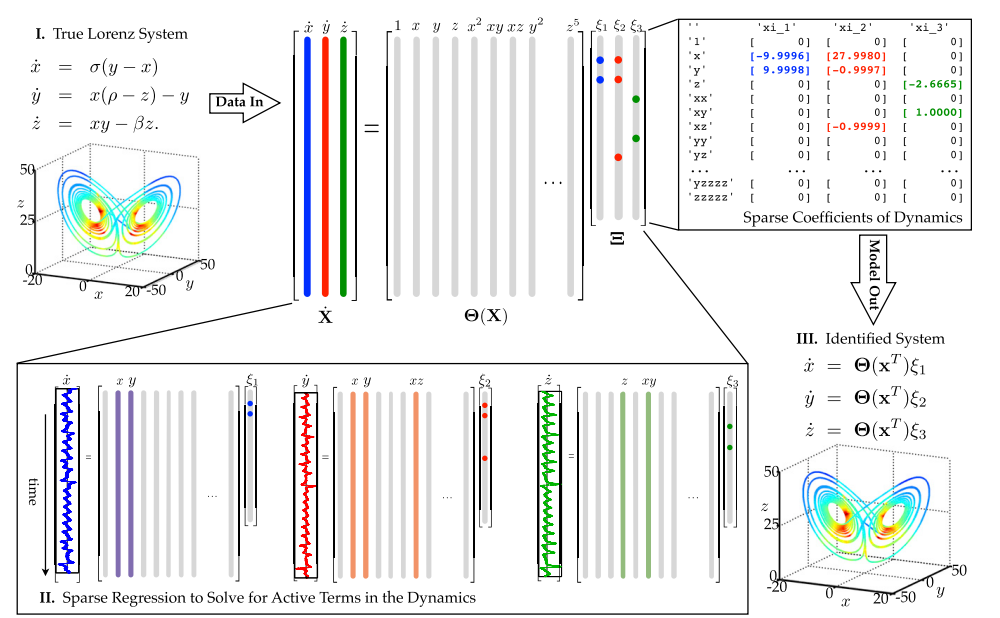

In [135]:
from IPython.display import Image
Image(filename='imagemSINDy.png')

# imagem do artigo: "Discovering governing equations from data by sparse identification of nonlinear dynamical systems"
# por: Steven L. Brunton, Joshua L. Proctor  e J. Nathan Kutz.

# Imports

In [136]:
pip install pysindy

In [137]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat

from scipy.integrate import solve_ivp

import pysindy as ps
# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# PySindy

O PySINDy é uma biblioteca para aplicar o algoritmo SINDy, vamos entender como ela funciona.
Em primeiro lugar, essa biblioteca possui as classes: SINDyEstimator e SINDyModel, não é muito importante para este trabalho como cada uma delas funciona individualmente já que elas estão integradas na criação de um só modelo que foi usado nesse trabalho. O modelo usado por essa biblioteca é importado do scikit learn, e é um MultiOutputRegressor.
Para auxiliar na preparação dos dados o PySindy possui classes de derivação numérica (visto que, em geral não temos as derivadas dos dados coletados). É possível escolher o método de diferenciação mais conveniente para os dados que o usuário tiver. Possui também otimizadores e uma biblioteca muito útil para a criação da matriz $\Theta(X)$, com uma função que cria as funções polinominais dado um grau máximo, função identidade para mapear os números neles próprios, funções trigonométricas, etc.

O PySINDy trabalha em 3 passos principais:

1: mapeia o input às funções não lineares da biblioteca selecionada;

2: organiza os dados como um problema de otimização;

3: multiplica as funções não lineares avaliadas nos dados com a matriz de coeficientes encapsulada em optimizer.


# Caso Unidimensional

$\dot{x} = 2x + 3x^2$

$x_0 = 0$


|x||||$\dot{x}$|
|-|-|-|-|-|
|1||$2(1) +3(1^2)$||5|
|2||$2(2) +3(2^2)$||16|
|3||$2(3) +3(3^2)$||33|
|4||$2(4) +3(4^2)$||56|
|5||$2(5) +3(5^2)$||85|



$$
\begin{bmatrix}
\dot{x}
\end{bmatrix} = \begin{bmatrix}
\ 1 & x & x^2 & x^3
\end{bmatrix}
\begin{bmatrix}
\xi
\end{bmatrix}
$$

$$
\begin{bmatrix}
 5 \\ 16 \\ 33 \\ 56 \\ 85
\end{bmatrix} = \begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 2 & 4 & 8 \\
1 & 3 & 9 & 27 \\
1 & 4 & 16 & 64 \\
1 & 5 & 25 & 125 \\
\end{bmatrix}
\begin{bmatrix}
 a_1 \\ a_2 \\ a_3 \\ a_4
\end{bmatrix}
$$


$$
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 2 & 4 & 8 \\
1 & 3 & 9 & 27 \\
1 & 4 & 16 & 64 \\
1 & 5 & 25 & 125 \\
\end{bmatrix}^T
\begin{bmatrix}
 5 \\ 16 \\ 33 \\ 56 \\ 85
\end{bmatrix} =
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 2 & 4 & 8 \\
1 & 3 & 9 & 27 \\
1 & 4 & 16 & 64 \\
1 & 5 & 25 & 125 \\
\end{bmatrix}^T
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 2 & 4 & 8 \\
1 & 3 & 9 & 27 \\
1 & 4 & 16 & 64 \\
1 & 5 & 25 & 125 \\
\end{bmatrix}
\begin{bmatrix}
 a_1 \\ a_2 \\ a_3 \\ a_4
\end{bmatrix}
$$



$$
\begin{bmatrix}
1 & 1 & 1 & 1 & 1 \\
1 & 2 & 3 & 4 & 5 \\
1 & 4 & 9 & 16 & 25 \\
1 & 8 & 27 & 64 & 125 \\
\end{bmatrix}
\begin{bmatrix}
 5 \\ 16 \\ 33 \\ 56 \\ 85
\end{bmatrix} =
\begin{bmatrix}
1 & 1 & 1 & 1 & 1 \\
1 & 2 & 3 & 4 & 5 \\
1 & 4 & 9 & 16 & 25 \\
1 & 8 & 27 & 64 & 125 \\
\end{bmatrix}
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 2 & 4 & 8 \\
1 & 3 & 9 & 27 \\
1 & 4 & 16 & 64 \\
1 & 5 & 25 & 125 \\
\end{bmatrix}
\begin{bmatrix}
 a_1 \\ a_2 \\ a_3 \\ a_4
\end{bmatrix}
$$


$$
\begin{bmatrix}
 195 \\ 785 \\ 3387 \\ 15233
\end{bmatrix} =
\begin{bmatrix}
5 & 15 & 55 & 225\\
15 & 55 & 225 & 979 \\
55 & 225 & 979 & 4425 \\
225 & 979 & 4425 & 20515 \\
\end{bmatrix}
\begin{bmatrix}
 a_1 \\ a_2 \\ a_3 \\ a_4
\end{bmatrix}
$$


$
195 = 5a_1 +  15a_2 +  55a_3 +  225a_4\\
785 = 15a_1 + 55a_2 + 225a_3 + 979a_4 \\
3387 = 55a_1 + 225a_2 + 979a_3 + 4425a_4 \\
15233 = 225a_1 + 979a_2 + 4425a_3 + 20515a_4 \\
$

substituindo

$a_1 = 0$

$a_2 = 2$

$a_3 = 3$

$a_4 = 0$

$
195 = 5(0) +  15(2) +  55(3) +  225(0)\\
785 = 15(0) + 55(2) + 225(3) + 979(0) \\
3387 = 55(0) + 225(2) + 979(3) + 4425(0) \\
15233 = 225(0) + 979(2) + 4425(3) + 20515(0) \\
$

$
195 = 15(2) +  55(3)\\
785 = 55(2) + 225(3)\\
3387 = 225(2) + 979(3) \\
15233 =979(2) + 4425(3) \\
$

$
195 = 30 +  165\\
785 = 110 + 675\\
3387 = 450 + 2937 \\
15233 = 1958 + 13275 \\
$






# Caso Linear

$$
\begin{bmatrix}
 \dot{x_1} \\ \dot{x_2}
\end{bmatrix} = \begin{bmatrix}
 -0.1 & 2 \\ -2 & -0.1
\end{bmatrix}
\begin{bmatrix}
 x_1 \\ x_2
\end{bmatrix}
$$

$$
t = 0 \implies
\begin{bmatrix}
 x_1 \\ x_2
\end{bmatrix} =
\begin{bmatrix}
 2 \\ 0
\end{bmatrix}
$$

In [138]:
#definindo a função para criação de dados
def f_lin(x, t):
  dot_x1 = -0.1*x[0] + 2*x[1]
  dot_x2 = -2*x[0] - 0.1*x[1]
  return [dot_x1,
          dot_x2]

#parâmetros para criação de dados, também usados no PySINDy
dt_lin = 0.1
t_train_lin = np.arange(0, 25, dt_lin) #intervalo dos dados(e de treino)
x0_train_lin = [2, 0] # função avaliada em t=0
x_train_lin = odeint(f_lin, x0_train_lin, t_train_lin) #resolvendo o sistema diferencial e avaliando em cada ponto variando em t.


In [139]:
# Modelo Caso Linear

poly_order = 3 #Matriz Theta será construída com polinômios de grau 3
threshold = 0.05 #lambda
feature_names_lin = ['x1', 'x2'] #nomeando nossas funções

#criando modelo no PySINDy
model = ps.SINDy(
    feature_names = feature_names_lin,
    optimizer = ps.STLSQ(threshold=threshold),
    feature_library = ps.PolynomialLibrary(degree=poly_order)
    )
model.fit(x_train_lin, t = dt_lin)
model.print()

(x1)' = -0.098 x1 + 1.987 x2
(x2)' = -1.988 x1 + -0.098 x2


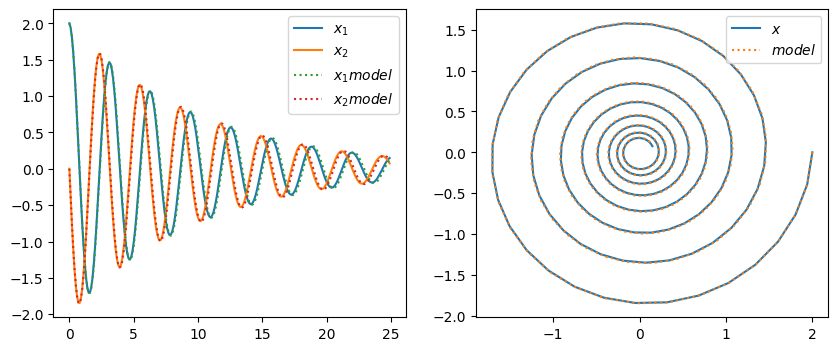

In [140]:
#Plot dos dados que criamos + os valores resultantes das funções geradas pelo modelo

sim_lin = model.simulate(x0_train_lin, t_train_lin)

fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(t_train_lin, x_train_lin[:,0], label = "$x_1$")
axs[0].plot(t_train_lin, x_train_lin[:,1], label = "$x_2$")
axs[0].plot(t_train_lin, sim_lin[:,0], label = "$x_1 model$", ls =':')
axs[0].plot(t_train_lin, sim_lin[:,1], label = "$x_2 model$", ls =':')

axs[0].legend()

axs[1].plot(x_train_lin[:,0], x_train_lin[:,1], label = "$x$")
axs[1].plot(sim_lin[:,0], sim_lin[:,1], label = "$model$", ls =':')

axs[1].legend()

fig.show()

O primeiro plot (do lado esquerdo) mostra as funções $x_1$ e $x_2$ encontradas pelo solver de EDO's odeint (os dados do problema), avaliadas no intervalo de 0 a 25 e as funções $x_1$ e $x_2$ encontradas pelo nosso modelo (pontilhado).

O segundo plot (do lado direito) mostra a dinâmica do sistema ($x_1$, $x_2$), também com a função resolvida pelo odeint e pelo modelo.

Note como o pontilhado está exatamente em cima dos dados.

# Caso Quadrático (problema)

$$
\begin{bmatrix}
 \dot{x_1} \\ \dot{x_2}
\end{bmatrix} = \begin{bmatrix}
 1 & 2 \\ 3 & 4
\end{bmatrix} \begin{bmatrix}
 x^2 \\ y^2
\end{bmatrix}
$$

In [141]:
#Caso Quad

def f_quad(xy, t):
  dot_x = 1*(xy[0]**2) + 2*(xy[1]**2)
  dot_y = 2*(xy[0]**2) + 3*(xy[1]**2)

  return [dot_x,
          dot_y]

dt_quad = 0.01
t_train_quad = np.arange(0, 25, dt_quad)
xy0_train_quad = [0, 0]
xy_train_quad = odeint(f_quad, xy0_train_quad, t_train_quad)


|$x$|$y$| |$\dot{x}$|$\dot{y}$|
|---|---|-|---------|---------|
| 1 | 1 | |    3    |    7    |
| 2 | 2 | |    12   |    28   |
| 3 | 3 | |    27   |    63   |
| 4 | 4 | |    48   |   112   |
| 5 | 5 | |    75   |   175   |

$$
\begin{bmatrix}
 3 & 7 \\
 3 & 7 \\
 12 & 28 \\
 27 & 63 \\
 48 & 112 \\
 75 & 175 \\
\end{bmatrix} = \begin{bmatrix}
 1 & x & y & x^2 & y^2 & xy \\
 1 & 1 & 1 & 1 & 1 & 1 \\
 1 & 2 & 2 & 4 & 4 & 4 \\
 1 & 3 & 3 & 9 & 9 & 9 \\
 1 & 4 & 4 & 16 & 16 & 16 \\
 1 & 5 & 5 & 25 & 25 & 25 \\
\end{bmatrix} \begin{bmatrix}
\xi_1 & \xi_2 \\
a_{11} & a_{21} \\
a_{12} & a_{22} \\
a_{13} & a_{23} \\
a_{14} & a_{24} \\
a_{15} & a_{25} \\
 \end{bmatrix}
 $$

In [142]:
# Modelo Caso Quad

poly_order = 3
threshold = 0.01
feature_names_quad = ['x', 'y']

model = ps.SINDy(
    feature_names = feature_names_quad,
    optimizer = ps.STLSQ(threshold=threshold),
    feature_library = ps.PolynomialLibrary(degree=poly_order)
    )
model.fit(xy_train_quad, t = dt_quad)
model.print()

(x)' = 0.000
(y)' = 0.000


Usei uma calculadora de equações diferenciais para resolver essa matriz e obtive como resultado que não há uma solução em funções elementares.

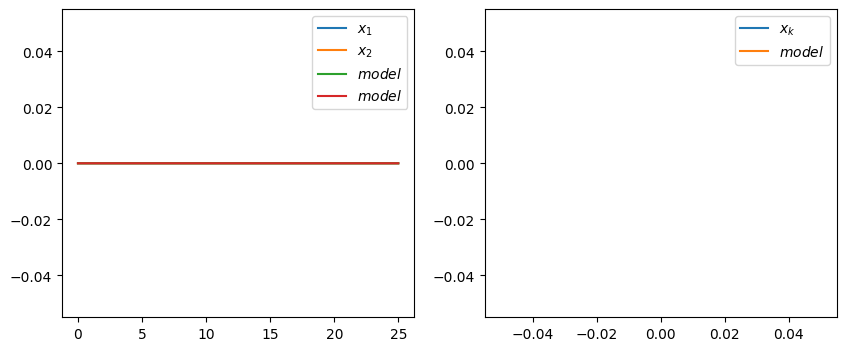

In [143]:
##Plot

sim_quad = model.simulate(xy0_train_quad, t_train_quad)

fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(t_train_quad, xy_train_quad[:,0], label = "$x_1$")
axs[0].plot(t_train_quad, xy_train_quad[:,1], label = "$x_2$")
axs[0].plot(t_train_quad, sim_quad[:,0], label = "$model$")
axs[0].plot(t_train_quad, sim_quad[:,1], label = "$model$")

axs[0].legend()

axs[1].plot(xy_train_quad[:,0], xy_train_quad[:,1], label = "$x_k$")
axs[1].plot(sim_quad[:,0], sim_quad[:,1], label = "$model$")

axs[1].legend()

fig.show()

# Caso Cúbico

$$
\begin{bmatrix}
 \dot{x_1} \\ \dot{x_2}
\end{bmatrix} = \begin{bmatrix}
 -0.1 & 2 \\ -2 & -0.1
\end{bmatrix}
\begin{bmatrix}
 x_1^3 \\ x_2^3
\end{bmatrix}
$$

$$
t = 0 \implies
\begin{bmatrix}
 x_1 \\ x_2
\end{bmatrix} =
\begin{bmatrix}
 2 \\ 0
\end{bmatrix}
$$

In [144]:
#definindo a função para criação de dados

def f_cub(x, t):
  dot_x1 = -0.1*(x[0]**3) + 2*(x[1]**3)
  dot_x2 = -2*(x[0]**3) - 0.1*(x[1]**3)

  return [dot_x1,
          dot_x2]
#parâmetros para criação de dados, também usados no PySINDy
dt_cub = 0.01
t_train_cub = np.arange(0, 25, dt_cub) #intervalo dos dados(e de treino)
x0_train_cub = [2, 0] #função avaliada em t=0
x_train_cub = odeint(f_cub, x0_train_cub, t_train_cub) #resolvendo o sistema diferencial e avaliando em cada ponto variando em t.

In [145]:
# Modelo Caso Cubico

poly_order = 3 #Matriz Theta será construída com polinômios de grau 3
threshold = 0.01 #lambda
feature_names_cub = ['x1', 'x2'] #nomeando nossas funções

#criando modelo no PySINDy
model = ps.SINDy(
    feature_names = feature_names_cub,
    optimizer = ps.STLSQ(threshold=threshold),
    feature_library = ps.PolynomialLibrary(degree=poly_order)
    )
model.fit(x_train_cub, t = dt_cub)
model.print()

(x1)' = -0.100 x1^3 + 1.999 x2^3
(x2)' = -1.999 x1^3 + -0.100 x2^3


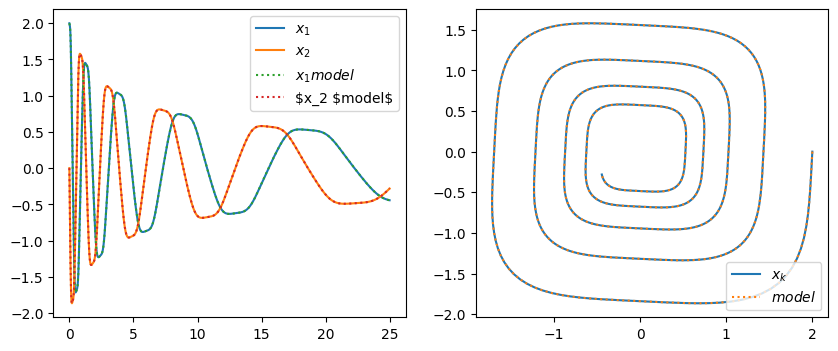

In [146]:
#Plot dos dados que criamos + os valores resultantes das funções geradas pelo modelo

sim_cub = model.simulate(x0_train_cub, t_train_cub)

fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(t_train_cub, x_train_cub[:,0], label = "$x_1$")
axs[0].plot(t_train_cub, x_train_cub[:,1], label = "$x_2$")
axs[0].plot(t_train_cub, sim_cub[:,0], label = "$x_1 model$", ls =':')
axs[0].plot(t_train_cub, sim_cub[:,1], label = "$x_2 $model$", ls =':')

axs[0].legend()

axs[1].plot(x_train_cub[:,0], x_train_cub[:,1], label = "$x_k$")
axs[1].plot(sim_cub[:,0], sim_cub[:,1], label = "$model$", ls =':')

axs[1].legend()

fig.show()

Assim como anteriormente, o primeiro plot mostra as funções $x_1$ e $x_2$ encontradas pelo solver de EDO's odeint, avaliadas no intervalo de 0 a 25 e as funções $x_1$ e $x_2$ encontradas pelo nosso modelo.

O segundo plot mostra a dinâmica do sistema ($x_1$, $x_2$), também com a função resolvida pelo odeint e pelo modelo.

Novamente temos o pontilhado exatamente em cima dos dados.

#Lorenz

O sistema de Lorenz é um sistema de equaçãoes diferenciais estudado pelo matemático e meteorologista Edward Lorenz, muito conhecida por ter soluções caóticas para certos parâmetros e condições iniciais.


$\dot{x} =  \sigma(y-x)$

$\dot{y} = x(\rho - z) - y$

$\dot{z} = xy - \beta z$

com $\sigma = 10$, $\rho =  28$, $\beta = \frac{8}{3}$.

condição inicial = $(-8, 8 , 27)$

In [147]:
#definindo a Equação de Lorenz para criação de dados

sigma, rho, beta = 10, 28, 8/3 #parametros da Equação de Lorenz

def f_lorenz(xyz, t):
  dot_x = sigma*(xyz[1] - xyz[0])
  dot_y = xyz[0]*(rho - xyz[2]) - xyz[1]
  dot_z = xyz[0]*xyz[1] - beta*xyz[2]
  return [dot_x,
          dot_y,
          dot_z]

#parâmetros para criação de dados, também usados no PySINDy
dt_lorenz = 0.001
t_train_lorenz = np.arange(0, 100, dt_lorenz)  #intervalo dos dados(e de treino)
xyz0_train_lorenz = [-8, 8, 27] #função avaliada em t=0
xyz_train_lorenz = odeint(f_lorenz, xyz0_train_lorenz, t_train_lorenz) #resolvendo o sistema diferencial e avaliando em cada ponto variando em t.

In [148]:
# Modelo Lorenz

poly_order = 3 #Matriz Theta será construída com polinômios de grau 3
threshold = 0.05 #lambda

feature_names_lorenz = ['x', 'y', 'z'] #nomeando nossas funções

#criando modelo no PySINDy
model = ps.SINDy(
    feature_names = feature_names_lorenz,
    optimizer = ps.STLSQ(threshold=threshold),
    feature_library = ps.PolynomialLibrary(degree=poly_order)
    )

model.fit(xyz_train_lorenz , t = dt_lorenz)
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [110]:
t_sim_lorenz = np.arange(0, 25, dt_lorenz)
sim_lorenz = model.simulate(xyz_train_lorenz[0], t_sim_lorenz)

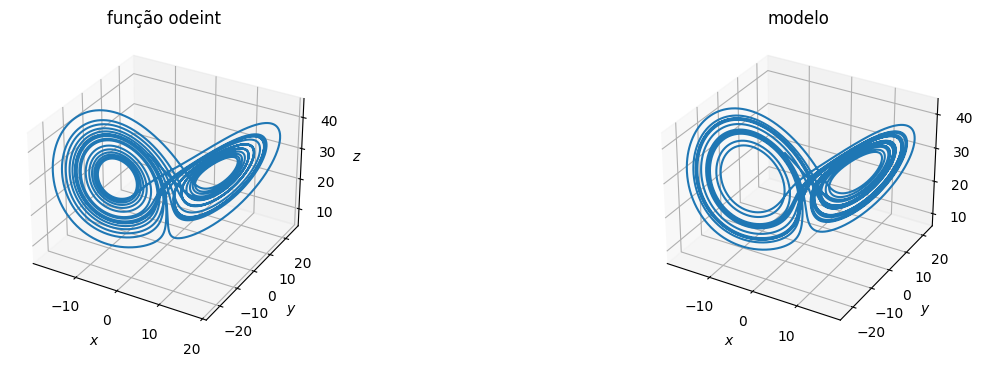

In [111]:
#Plot dos dados que criamos + os valores resultantes das funções geradas pelo modelo

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(121, projection = '3d')
ax.plot(
    xyz_train_lorenz[: t_sim_lorenz.size, 0],
    xyz_train_lorenz[: t_sim_lorenz.size, 1],
    xyz_train_lorenz[: t_sim_lorenz.size, 2],
)
plt.title('função odeint')
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

#MODELO
ax = fig.add_subplot(122, projection = '3d')
ax.plot(
    sim_lorenz[:,0],
    sim_lorenz[:,1],
    sim_lorenz[:,2]
)
plt.title('modelo')
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig.show()

No primeiro plot(a esquerda) temos os dados do problema, encontrados pela função odeint, no segundo (a direita) temos a simulação do dinâmica encontrada pelo nosso modelo.

# Navier Stokes
Essas equações descrevem como a velocidade, pressão, temperatura e densidade de um fluido estão relacionadas. Foram encontradas independentememnte por Stokes na Inglaterar e Navier na França, em 1800.



$\dot{x_1} = -2x_1 + a_1x_2x_3 + a_2x_4x_5$

$\dot{x_2} = -9x_2 + bx_1x_3$

$\dot{x_3} = -5x_3 - cx_1x_2 + Re$

$\dot{x_4} = -5x_4 - dx_1x_5$

$\dot{x_5} = -x_5 - ex_1x_5$

vamos definir

$a_1, a_2 = 15, 1 $

$b = 2.3$

$c, Re = 5, 4 $

$d = 0$

$e = 3$

In [112]:
a1, a2, b, c, Re, d, e = 15, 1, 2.3, 5, 4, 0, 3
def f_NS(x, t):
  x1_dot = -2*x[0] + a1*x[1]*x[2] + a2*x[3]*x[4]
  x2_dot = -9*x[1] + b*x[0]*x[2]
  x3_dot = -5*x[2] - c*x[0]*x[1] + Re
  x4_dot = -5*x[3] - d*x[0]*x[4]
  x5_dot = -x[4] - e*x[0]*x[4]

  return [x1_dot,
          x2_dot,
          x3_dot,
          x4_dot,
          x5_dot
          ]

dt_NS = 0.01
t_train_NS = np.arange(0, 3, dt_NS)
x0_train_NS = [2, 1, 3, 1, 4]
x_train_NS = odeint(f_NS, x0_train_NS, t_train_NS)
#x_dot_train_measured_NS = np.array([f_NS(x_train_NS[i],0) for i in range(t_train_NS.size)])


In [113]:
poly_order = 2
threshold = 0.1

feature_names_NS = ['x1', 'x2', 'x3', 'x4', 'x5']

model = ps.SINDy(
    feature_names = feature_names_NS,
    optimizer = ps.STLSQ(threshold=threshold),
    feature_library = ps.PolynomialLibrary(degree=poly_order)
    )
model.fit(x_train_NS, t = dt_NS)
model.print()

(x1)' = 2.228 1 + -3.791 x1 + 3.731 x2 + -3.861 x3 + -46.863 x5 + 0.249 x1^2 + -0.008 x1 x2 + 0.674 x1 x3 + -4.619 x1 x4 + 7.493 x1 x5 + 5.431 x2^2 + 13.940 x2 x3 + 29.603 x2 x4 + -21.506 x2 x5 + 1.667 x3^2 + 16.194 x3 x4 + 16.962 x3 x5 + 184.723 x4^2 + -69.184 x4 x5 + 1.501 x5^2
(x2)' = 3.659 1 + 1.478 x1 + 0.269 x2 + -8.681 x3 + -19.168 x4 + 285.852 x5 + -2.861 x1^2 + -2.226 x1 x2 + 2.270 x1 x3 + -25.587 x1 x5 + 14.781 x2^2 + 3.284 x3^2 + 77.319 x3 x4 + -23.521 x3 x5 + -245.810 x4 x5 + 6.010 x5^2
(x3)' = 3.876 1 + -0.026 x1 + -5.428 x2 + -6.094 x3 + 0.365 x1^2 + -5.052 x1 x2 + 1.007 x1 x3 + -4.563 x1 x4 + -0.121 x1 x5 + 5.107 x2^2 + -0.039 x2 x3 + 11.696 x2 x4 + 1.707 x3^2 + -18.098 x3 x4 + 5.243 x3 x5 + -1.814 x5^2
(x4)' = 0.326 1 + -0.185 x1^2 + 0.256 x1 x2 + -0.717 x2^2 + -0.497 x3^2
(x5)' = 0.257 x3 + 0.653 x5 + -0.612 x1 x4 + -2.420 x1 x5 + -0.322 x2^2 + -0.243 x2 x3 + -1.178 x2 x4 + -1.511 x2 x5 + -0.317 x3^2


In [114]:
t_sim_NS = np.arange(0,3, dt_NS)
sim_NS = model.simulate(x0_train_NS, t_sim_NS)

threshold = 0.1


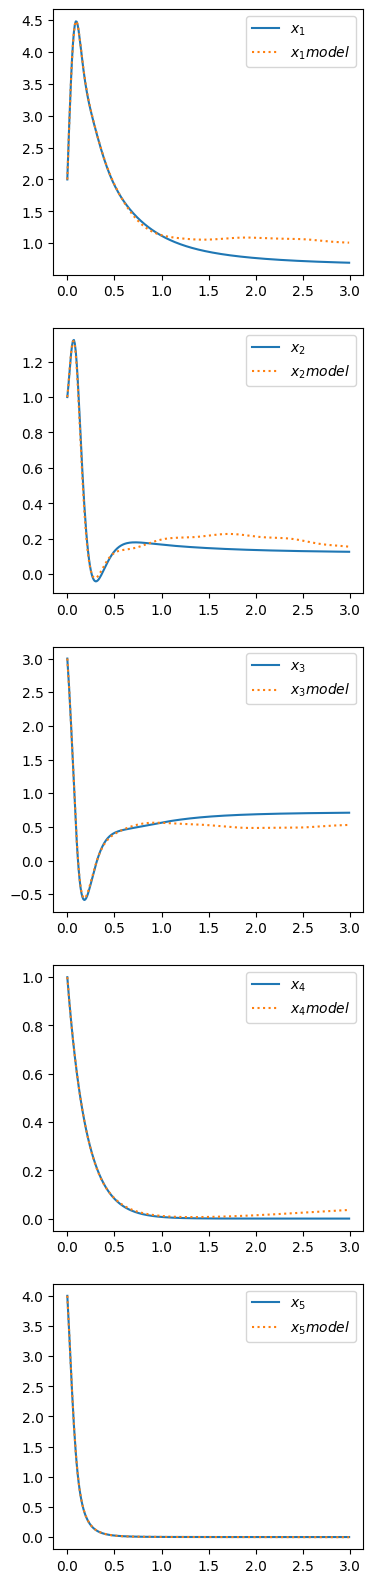

In [115]:
#Plot dos dados que criamos + os valores resultantes das funções geradas pelo modelo

print(f'threshold = {threshold}')
fig, ax = plt.subplots(nrows=5, ncols=1, figsize = (4,20))
for i in range(5):
  ax[i].plot(t_train_NS,x_train_NS[:,i], label = f"$x_{i+1}$")
  ax[i].plot(t_sim_NS, sim_NS[:,i], label = f"$x_{i+1} model$", ls =':' )
  ax[i].legend()


plt.show()

Como o resultado não foi tão bom quanto os outros, testei para um treshold maior.

In [116]:
threshold = 0.2
model = ps.SINDy(
    feature_names = feature_names_NS,
    optimizer = ps.STLSQ(threshold=threshold),
    feature_library = ps.PolynomialLibrary(degree=poly_order)
    )
model.fit(x_train_NS, t = dt_NS)
model.print()

(x1)' = 0.880 1 + -2.858 x1 + 2.584 x2 + -1.102 x3 + -0.052 x1 x2 + 0.271 x1 x3 + -3.756 x1 x4 + 3.280 x1 x5 + 2.450 x2^2 + 14.638 x2 x3 + 10.996 x2 x4 + -21.137 x2 x5 + 0.069 x3^2 + 14.941 x3 x4 + 6.840 x3 x5 + 73.976 x4^2 + -17.749 x4 x5 + -4.561 x5^2
(x2)' = -0.045 1 + -0.646 x1 + -7.039 x2 + 0.244 x3 + 0.268 x1^2 + -0.223 x1 x2 + 2.392 x1 x3 + -0.346 x1 x5 + -0.161 x3^2 + -1.404 x3 x4 + 2.828 x3 x5 + -1.739 x5^2
(x3)' = 4.530 1 + -1.330 x1 + 2.783 x2 + -3.287 x3 + 0.441 x1^2 + -4.883 x1 x2 + -0.383 x1 x3 + -6.289 x2^2 + 1.700 x2 x3 + 2.407 x2 x4 + -2.502 x3^2 + 2.573 x3 x5 + -0.939 x5^2
(x4)' = -0.649 x3^2
(x5)' = -0.654 x5 + -0.317 x1 x4 + -2.694 x1 x5 + -0.846 x2 x5


Note como as funções ficam menores com o aumento do threshold.

In [117]:
t_sim_NS = np.arange(0,3, dt_NS)
sim_NS = model.simulate(x0_train_NS, t_sim_NS)

threshold = 0.2


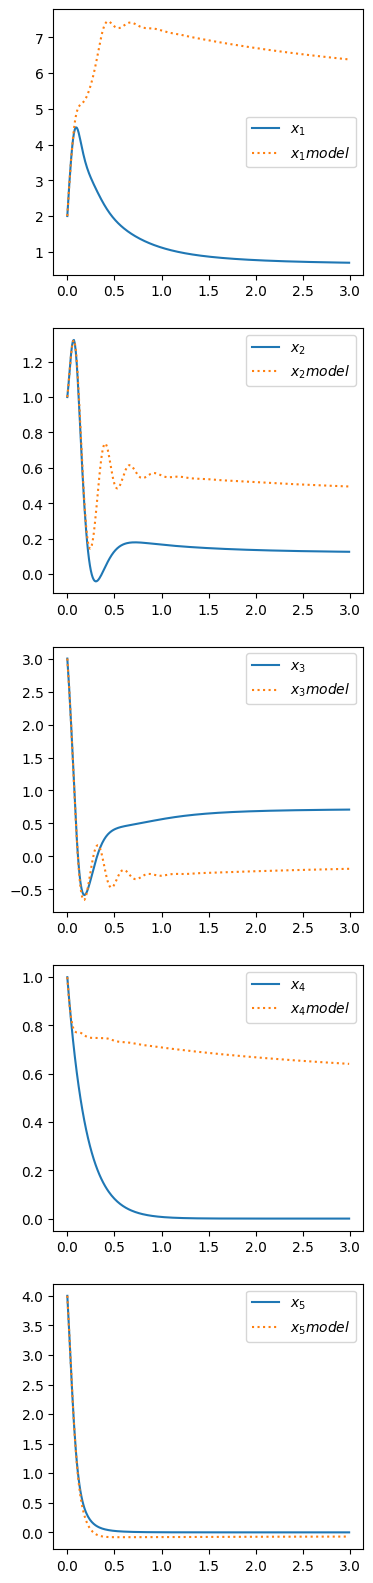

In [118]:
print(f'threshold = {threshold}')
fig, ax = plt.subplots(nrows=5, ncols=1, figsize = (4,20))
for i in range(5):
  ax[i].plot(t_train_NS,x_train_NS[:,i], label = f"$x_{i+1}$")
  ax[i].plot(t_sim_NS, sim_NS[:,i], label = f"$x_{i+1} model$", ls =':' )
  ax[i].legend()


plt.show()

# Alguns testes

Aqui testamos como a mudança no lambda (o threshold), a mudança na biblioteca de funções e o acréscimo de ruído altera nosso resultado.

#Mexendo em lambda

In [119]:
# Modelo Caso Linear
poly_order = 3
thresholds = [0.001, 0.01, 0.1, 1, 2] #lambdas

for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_lin,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=poly_order)
      )
  model.fit(x_train_lin, t = dt_lin)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.001
(x1)' = -0.098 x1 + 1.987 x2
(x2)' = -1.984 x1 + -0.097 x2 + -0.002 x1^2 + -0.001 x1 x2 + -0.003 x1^3 + -0.002 x1^2 x2

lambda = 0.01
(x1)' = -0.098 x1 + 1.987 x2
(x2)' = -1.988 x1 + -0.098 x2

lambda = 0.1
(x1)' = 1.992 x2
(x2)' = -1.984 x1

lambda = 1
(x1)' = 1.992 x2
(x2)' = -1.984 x1

lambda = 2
(x1)' = 0.000
(x2)' = 0.000



/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (2) and eliminated all coefficients
  warnings.warn(


In [120]:
#Modelo Caso Cubico

poly_order = 3
thresholds = [0.001, 0.01, 0.1, 0.5, 1] #lambdas

for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_cub,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=poly_order)
      )
  model.fit(x_train_cub, t = dt_cub)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.001
(x1)' = 0.001 x2 + -0.101 x1^3 + 0.002 x1^2 x2 + 0.001 x1 x2^2 + 1.998 x2^3
(x2)' = -0.001 x1 + -1.998 x1^3 + -0.002 x1 x2^2 + -0.100 x2^3

lambda = 0.01
(x1)' = -0.100 x1^3 + 1.999 x2^3
(x2)' = -1.999 x1^3 + -0.100 x2^3

lambda = 0.1
(x1)' = -0.100 x1^3 + 1.999 x2^3
(x2)' = -1.994 x1^3

lambda = 0.5
(x1)' = 2.004 x2^3
(x2)' = -1.994 x1^3

lambda = 1
(x1)' = 2.004 x2^3
(x2)' = -1.994 x1^3



In [121]:
#Modelo Lorenz

poly_order = 3
thresholds = [0.01, 0.1, 0.5, 1, 2] #lambdas

for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_lorenz,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=poly_order)
      )
  model.fit(xyz_train_lorenz , t = dt_lorenz)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.01
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

lambda = 0.1
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

lambda = 0.5
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

lambda = 1
(x)' = -10.000 x + 10.000 y
(y)' = -2.764 x
(z)' = 0.000

lambda = 2
(x)' = -10.000 x + 10.000 y
(y)' = -2.764 x
(z)' = 0.000



/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (2) and eliminated all coefficients
  warnings.warn(


Podemos perceber como um lambda pequeno demais faz com que nossa matriz não fique tão esparsa e tenhamos mais funções lineares para descrever os dados com mais precisão, mas, se aumemntarmos muito o lambda, a matriz torna-se tão esparsa que acabamos por perder informação da nossa dinâmica.

In [122]:
#Modelo Navier Stokes

poly_order = 2
thresholds = [0.05, 0.1, 0.25, 0.5, 1, 2] #lambdas


for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_NS,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=poly_order)
      )
  model.fit(x_train_NS , t = dt_NS)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.05
(x1)' = 2.228 1 + -3.791 x1 + 3.731 x2 + -3.861 x3 + -46.863 x5 + 0.249 x1^2 + -0.008 x1 x2 + 0.674 x1 x3 + -4.619 x1 x4 + 7.493 x1 x5 + 5.431 x2^2 + 13.940 x2 x3 + 29.603 x2 x4 + -21.506 x2 x5 + 1.667 x3^2 + 16.194 x3 x4 + 16.962 x3 x5 + 184.723 x4^2 + -69.184 x4 x5 + 1.501 x5^2
(x2)' = 39.741 1 + -18.723 x1 + 30.096 x2 + -82.644 x3 + 6.717 x4 + -838.172 x5 + 0.089 x1^2 + 2.774 x1 x2 + 11.809 x1 x3 + 63.003 x1 x5 + 95.543 x2^2 + -23.475 x2 x3 + 394.469 x2 x4 + 66.322 x2 x5 + 44.811 x3^2 + 117.402 x3 x4 + 209.134 x3 x5 + 2720.358 x4^2 + -1656.319 x4 x5 + 183.796 x5^2
(x3)' = -2.254 1 + 2.920 x1 + -6.973 x2 + 8.301 x3 + 46.537 x4 + 0.032 x1^2 + -3.364 x1 x2 + -2.057 x1 x3 + -19.031 x1 x4 + -3.163 x1 x5 + -10.561 x2^2 + 1.921 x2 x3 + -49.604 x2 x4 + 59.074 x2 x5 + -6.909 x3^2 + -51.045 x3 x4 + -15.142 x3 x5 + -20.010 x4 x5 + 18.030 x5^2
(x4)' = -0.004 x2 + -5.008 x4 + 0.002 x1 x2 + -0.001 x1 x5 + 0.001 x3^2 + 0.001 x3 x5
(x5)' = 0.092 x1 + -10.481 x2 + 0.777 x3 + -34.556 x5

/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coeffici

Esse caso já havia apresentado resultados ruins, mas podemos ver analisando o crescimento de lambda como a função $(x_3)'$ torna-se nula antes das outras funções se adequarem às funções que desejamos.

O próprio PySINDy tem um aviso a respeito do paramêtro de esparsidade estar muito grande e consequentememnte eliminando os coeficientes de uma coluna $\xi_k$

# Biblioteca de Funções

In [123]:
functions = [lambda x : np.exp(x), lambda x,y : np.sin(x+y)]
lib_custom = ps.CustomLibrary(library_functions=functions)
lib_fourier = ps.FourierLibrary()
lib_concat = ps.ConcatLibrary([lib_custom, lib_fourier,
                               ps.PolynomialLibrary(degree=5) ])

lib_concat2 = ps.ConcatLibrary([lib_custom, lib_fourier,
                               ps.PolynomialLibrary(degree=2) ])


Aqui usamos a função de biblioteca personalizada do PySINDy, acrescentando a função exponencial e uma função que calcula o seno da soma de dois valores. Usamos a função que concatena essas bibliotecas para acrescentar também "FourierLibrary" com as funções trigonométricas e as funções polinomiais de grau máximo 5 (até então estávamos usando grau máximo 3).

obs.: a biblioteca concat2 é usada para o caso Navier Stokes pois esse é um sistema de 5 equações e gastaríamos espaço (e tempo) desnecessário para calcular $\Theta(X)$.


Calculamos modelos diferentes em função do lambda novamente para pecebermos quando as novas funções "somem" dado quão esparsa está nossa matriz.

In [124]:
#Modelo Caso Linear

thresholds = [0.001, 0.01, 0.05, 0.1, 0.12, 0.5 ] #lambdas

for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_lin,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library =lib_concat
      )
  model.fit(x_train_lin, t = dt_lin)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.001
(x1)' = -0.999 f0(x1) + -3.531 f0(x2) + -0.058 f1(x1,x2) + 1.290 sin(1 x1) + -1.126 cos(1 x1) + -5.700 sin(1 x2) + -4.441 cos(1 x2) + 10.097 1 + -0.331 x1 + 11.275 x2 + -0.064 x1^2 + -0.454 x2^2 + 0.370 x1^3 + -0.027 x1^2 x2 + -0.028 x1 x2^2 + -0.370 x2^3 + 0.088 x1^4 + 0.330 x2^4 + 0.001 x1^4 x2 + 0.004 x1^3 x2^2 + 0.004 x1^2 x2^3 + 0.002 x1 x2^4 + 0.076 x2^5
(x2)' = -25.516 f0(x1) + 4.521 f0(x2) + 0.160 f1(x1,x2) + -29.443 sin(1 x1) + -30.964 cos(1 x1) + -5.631 sin(1 x2) + 4.466 cos(1 x2) + 47.492 1 + 52.811 x1 + 0.850 x2 + -2.717 x1^2 + 0.002 x1 x2 + -0.026 x2^2 + -0.626 x1^3 + 0.083 x1^2 x2 + 0.080 x1 x2^2 + -1.658 x2^3 + 2.341 x1^4 + -0.003 x1^3 x2 + -0.001 x1^2 x2^2 + -0.376 x2^4 + 0.455 x1^5 + -0.009 x1^4 x2 + -0.013 x1^3 x2^2 + -0.010 x1^2 x2^3 + -0.005 x1 x2^4

lambda = 0.01
(x1)' = -1.475 f0(x1) + 0.074 f0(x2) + -0.003 f1(x1,x2) + 1.847 sin(1 x1) + -1.823 cos(1 x1) + -0.107 sin(1 x2) + 3.224 1 + -0.467 x1 + 2.022 x2 + -0.174 x1^2 + -0.036 x2^2 + 0.550 x1^3 + -0

In [125]:
#Modelo Caso Cubico

thresholds = [0.001, 0.01, 0.05, 0.09, 0.1, 1] #lambdas

for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_cub,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = lib_concat
      )
  model.fit(x_train_cub, t = dt_cub)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.001
(x1)' = 0.281 f0(x1) + 0.672 f0(x2) + -0.008 f1(x1,x2) + -0.344 sin(1 x1) + 0.409 cos(1 x1) + -0.870 sin(1 x2) + 0.712 cos(1 x2) + -2.074 1 + 0.072 x1 + 0.206 x2 + 0.064 x1^2 + 0.020 x2^2 + -0.205 x1^3 + -0.005 x1^2 x2 + -0.005 x1 x2^2 + 1.744 x2^3 + -0.028 x1^4 + -0.058 x2^4 + 0.004 x1^4 x2 + 0.001 x1^3 x2^2 + -0.003 x1^2 x2^3 + 0.001 x1 x2^4
(x2)' = -0.334 f0(x1) + -0.055 f0(x2) + -0.021 f1(x1,x2) + 0.503 sin(1 x1) + -0.418 cos(1 x1) + 0.083 sin(1 x2) + 0.093 cos(1 x2) + 0.713 1 + -0.149 x1 + -0.007 x2 + -0.042 x1^2 + 0.073 x2^2 + -1.866 x1^3 + -0.010 x1^2 x2 + -0.009 x1 x2^2 + -0.081 x2^3 + 0.031 x1^4 + -0.001 x2^4 + 0.005 x1^3 x2^2 + 0.002 x1^2 x2^3 + -0.003 x1 x2^4

lambda = 0.01
(x1)' = -0.082 f0(x1) + -0.103 f0(x2) + 0.082 cos(1 x1) + -0.003 sin(1 x2) + 0.138 cos(1 x2) + -0.035 1 + 0.081 x1 + 0.106 x2 + 0.083 x1^2 + 0.119 x2^2 + -0.084 x1^3 + 2.018 x2^3
(x2)' = -0.117 f0(x1) + 0.280 sin(1 x1) + 0.154 cos(1 x1) + 0.108 sin(1 x2) + -0.037 1 + -0.163 x1 + -0.107 x2 +

Nestes dois casos vemos como a escolha da biblioteca é importante pois as funções não chegaram no formato desejado pois o seno parecia estar aproximando melhor os dados do que as funções de fato.

In [126]:
#Modelo Lorenz

thresholds = [0.001, 0.005, 0.1, 1, 2] #lambdas

for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_lorenz,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = lib_concat
      )
  model.fit(xyz_train_lorenz , t = dt_lorenz)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.001
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

lambda = 0.005
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

lambda = 0.1
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y



/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(


lambda = 1
(x)' = -10.000 x + 10.000 y
(y)' = -12.686 x + 9.926 y
(z)' = 0.000

lambda = 2
(x)' = -10.000 x + 10.000 y
(y)' = -2.764 x
(z)' = 0.000



/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (2) and eliminated all coefficients
  warnings.warn(


Aqui a alteração da biblioteca não foi relevante para o resultado, mas com certeza demandou mais espaço e tempo no computador devido a avaliação desnecessária dessas funções nos pontos dados.

In [127]:
#Modelo Navier Stokes

thresholds = [0.1, 0.5, 0.75, 1, 2] #lambdas


for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_NS,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = lib_concat2
      )
  model.fit(x_train_NS , t = dt_NS)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.1
(x1)' = -0.275 f0(x1) + 143.838 f0(x2) + -3.085 f0(x5) + 0.951 f1(x1,x2) + -0.173 f1(x1,x3) + 7.100 f1(x1,x4) + 10.484 f1(x1,x5) + -0.295 f1(x2,x3) + -120.104 f1(x2,x4) + -41.594 f1(x2,x5) + 10.422 f1(x3,x4) + -2.389 f1(x3,x5) + -711.349 f1(x4,x5) + -27.655 sin(1 x1) + -3.213 cos(1 x1) + 370.816 sin(1 x2) + -73.882 cos(1 x2) + -29.541 sin(1 x3) + 13.127 cos(1 x3) + -9227.204 sin(1 x4) + 634.145 cos(1 x4) + 673.004 sin(1 x5) + 761.259 cos(1 x5) + -1457.610 1 + -8.526 x1 + -335.253 x2 + 10094.751 x4 + -0.196 x1^2 + -7.618 x1 x2 + 17.817 x1 x3 + -24.389 x1 x4 + 78.106 x1 x5 + -103.816 x2^2 + -4.229 x2 x3 + 45.319 x2 x4 + -336.698 x2 x5 + 8.918 x3^2 + -6.380 x3 x4 + 74.021 x3 x5 + -66.438 x5^2
(x2)' = -355.092 f0(x2) + -18.689 f0(x3) + 6.912 f1(x1,x2) + 27.772 f1(x1,x3) + 149.882 f1(x1,x4) + 68.459 f1(x2,x3) + -212.749 f1(x2,x4) + 870.115 f1(x2,x5) + -147.728 f1(x3,x4) + -93.402 sin(1 x1) + -68.885 cos(1 x1) + -1412.240 sin(1 x2) + 467.060 sin(1 x3) + 229.577 cos(1 x3) + 990.4

/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.75) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.75) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coef

Aumentar a biblioteca definitivamente não resolveu nenhum dos problemas anteriores e possivelmente os agravou.

In [128]:
#Modelo Caso Cubico

thresholds = [0.001, 0.01, 0.05, 0.09, 0.1, 1] #lambdas

for tr in thresholds:
  model = ps.SINDy(
      feature_names = feature_names_cub,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=2) #biblioteca apenas com polinômios de grau 2
      )
  model.fit(x_train_cub, t = dt_cub)
  print(f'lambda = {tr}')
  model.print()
  print()

lambda = 0.001
(x1)' = 0.371 1 + -0.193 x1 + 2.086 x2 + -0.138 x1^2 + -0.008 x1 x2 + -0.701 x2^2
(x2)' = 0.099 1 + -2.157 x1 + -0.014 x2 + -0.159 x1^2 + 0.388 x1 x2 + 0.002 x2^2

lambda = 0.01
(x1)' = 0.371 1 + -0.192 x1 + 2.086 x2 + -0.137 x1^2 + -0.700 x2^2
(x2)' = 0.100 1 + -2.157 x1 + -0.014 x2 + -0.159 x1^2 + 0.388 x1 x2

lambda = 0.05
(x1)' = 0.371 1 + -0.192 x1 + 2.086 x2 + -0.137 x1^2 + -0.700 x2^2
(x2)' = 0.100 1 + -2.157 x1 + -0.158 x1^2 + 0.388 x1 x2

lambda = 0.09
(x1)' = 0.371 1 + -0.192 x1 + 2.086 x2 + -0.137 x1^2 + -0.700 x2^2
(x2)' = 0.100 1 + -2.157 x1 + -0.158 x1^2 + 0.388 x1 x2

lambda = 0.1
(x1)' = 0.371 1 + -0.192 x1 + 2.086 x2 + -0.137 x1^2 + -0.700 x2^2
(x2)' = -2.153 x1 + 0.404 x1 x2

lambda = 1
(x1)' = 2.123 x2
(x2)' = -2.182 x1



Apenas um experimento com o caso cúbico, para ver como se comporta o algoritmo no caso em que não temos disponível a função que precisaríamos  para descrever o sistema.

# Ruido

In [129]:
np.random.seed(0)

Adicionamos um ruído gaussiano nos "dados coletados" variando a escala do ruído. Esse teste é importante pois sabemos que na vida real a maior parte das medições não pode ser feita de maneira completamente perfeita e precisa como nos casos apresentados anteriormente em que os dados são o exato resultado da aplicação da função em um ponto.

In [130]:
# Modelo Caso Linear
poly_order = 3
threshold = 0.05 #lambda #Obs.: deixei o lambda que deu certo inicialmente

ruidos = [1e-7, 1e-4, 0.01, 0.1, 1.0, 2.0]

for eps in ruidos:
  model = ps.SINDy(
      feature_names = feature_names_lin,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=poly_order)
      )

  model.fit(x_train_lin +
            np.random.normal(scale=eps, size=x_train_lin.shape), #ruido
            t = dt_lin)
  print(f'eps= {eps}')
  model.print()
  print()

eps= 1e-07
(x1)' = 1.992 x2
(x2)' = -1.984 x1

eps= 0.0001
(x1)' = 1.992 x2
(x2)' = -1.984 x1

eps= 0.01
(x1)' = 1.986 x2
(x2)' = -1.991 x1

eps= 0.1
(x1)' = 1.973 x2
(x2)' = -1.912 x1

eps= 1.0
(x1)' = 1.083 x2
(x2)' = 0.000

eps= 2.0
(x1)' = 1.310 x2
(x2)' = -1.246 x1



/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(


In [131]:
#Modelo Caso Cubico


poly_order = 3
threshold = 0.001 #lambda

ruidos = [1e-7, 1e-3, 0.01, 0.5, 1.0, 2.0]

for eps in ruidos:
  model = ps.SINDy(
      feature_names = feature_names_cub,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=poly_order)
      )
  model.fit(x_train_cub +
            np.random.normal(scale=eps, size=x_train_cub.shape), #ruido
            t = dt_cub)
  print(f'eps = {eps}')
  model.print()
  print()

eps = 1e-07
(x1)' = 2.004 x2^3
(x2)' = -1.994 x1^3

eps = 0.001
(x1)' = 2.004 x2^3
(x2)' = -1.993 x1^3

eps = 0.01
(x1)' = 2.007 x2^3
(x2)' = -1.979 x1^3

eps = 0.5
(x1)' = 1.217 x1 + 1.195 x1^2 x2 + -2.035 x1 x2^2
(x2)' = 0.000

eps = 1.0
(x1)' = 0.000
(x2)' = -1.360 x1 + 1.031 x1 x2^2

eps = 2.0
(x1)' = 2.490 x2
(x2)' = -2.391 x1



/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(


Nestes dois casos, qualquer ruído, ainda que pequeno, já impossibilitou a descoberta da dinâmica pelo PySINDy.

In [132]:
# Modelo Lorenz

poly_order = 3
threshold = 0.05 #lambda #O mesmo que apresentou bons resultados no primeiro teste.

ruidos = [1e-3, 1e-2, 0.1, 0.5, 1.0, 2.0]

for eps in ruidos:
  model = ps.SINDy(
      feature_names = feature_names_lorenz,
     optimizer = ps.STLSQ(threshold=threshold),
     feature_library = ps.PolynomialLibrary(degree=poly_order)
     )

  model.fit(xyz_train_lorenz +
            np.random.normal(scale=eps, size=xyz_train_lorenz.shape), #ruido
            t = dt_lorenz)
  print(f'eps = {eps}')
  model.print()
  print()

eps = 0.001
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

eps = 0.01
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -0.999 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

eps = 0.1
(x)' = -9.988 x + 9.989 y
(y)' = 27.948 x + -0.985 y + -0.999 x z
(z)' = -2.666 z + 1.000 x y

eps = 0.5
(x)' = -9.673 x + 9.712 y
(y)' = -1.032 1 + -6.782 x + 20.641 y + -0.133 z + -0.625 y z
(z)' = -0.233 1 + -2.644 z + 0.995 x y

eps = 1.0
(x)' = 1.205 1 + 0.440 x + 3.970 y + -0.265 x z + 0.135 y z
(y)' = -0.812 1 + 21.180 x + 2.864 y + -0.811 x z + -0.101 y z
(z)' = -4.479 1 + 0.338 x + -0.291 y + -2.349 z + -0.064 x^2 + 1.019 x y

eps = 2.0
(x)' = -3.844 1 + 8.014 x + -0.698 y + 0.340 z + -0.080 x^2 + 0.124 x y + -0.430 x z + -0.052 y^2 + 0.213 y z
(y)' = 14.758 1 + -4.096 x + 18.169 y + -1.854 z + -0.243 x^2 + 0.264 x y + -0.079 y^2 + -0.615 y z + 0.050 z^2
(z)' = -12.954 1 + -0.403 x + 0.318 y + -1.927 z + 0.683 x y + 0.181 y^2



Aqui vemos o PySINDy tolera pequenos ruídos mas não tanto, entretanto, alterando o lambda para tornar a matriz mais esparsa conseguimos aumentar um pouco a tolerância do código à ruídos, por isso todos os parâmetros devem ser bem avaliados.

In [133]:
# Modelo Lorenz

poly_order = 3
threshold = 0.1 #lambda

ruidos = [1e-3, 1e-2, 0.1, 0.5, 1.0, 2.0]

for eps in ruidos:
  model = ps.SINDy(
      feature_names = feature_names_lorenz,
     optimizer = ps.STLSQ(threshold=threshold),
     feature_library = ps.PolynomialLibrary(degree=poly_order)
     )

  model.fit(xyz_train_lorenz +
            np.random.normal(scale=eps, size=xyz_train_lorenz.shape), #ruido
            t = dt_lorenz)
  print(f'eps = {eps}')
  model.print()
  print()

eps = 0.001
(x)' = -10.000 x + 10.000 y
(y)' = 27.998 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

eps = 0.01
(x)' = -9.999 x + 10.000 y
(y)' = 27.997 x + -0.999 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

eps = 0.1
(x)' = -9.989 x + 9.991 y
(y)' = 27.960 x + -0.988 y + -0.999 x z
(z)' = -2.666 z + 1.000 x y

eps = 0.5
(x)' = 0.127 1 + -9.723 x + 9.761 y
(y)' = -0.163 1 + 26.551 x + -0.533 y + -0.968 x z
(z)' = -0.169 1 + -2.642 z + 0.993 x y

eps = 1.0
(x)' = 4.211 y + -0.256 x z + 0.131 y z
(y)' = -0.985 1 + 19.532 x + 3.640 y + -0.769 x z + -0.116 y z
(z)' = -1.051 1 + -2.563 z + 0.978 x y

eps = 2.0
(x)' = 2.049 1 + 9.338 x + -0.785 y + -0.472 x z + 0.212 y z
(y)' = -1.126 1 + 17.394 x + 4.622 y + -0.690 x z + -0.157 y z
(z)' = -2.244 1 + 0.352 x + -0.386 y + -2.629 z + 0.212 x^2 + 0.535 x y + 0.195 y^2



In [134]:
#Modelo Navier Stokes

poly_order = 2
thresholds = [0.05, 0.1, 0.5, 1, 2] #lambdas

ruidos = [1e-3, 1e-2, 0.1, 0.5, 1.0, 2.0]
for eps in ruidos:
  model = ps.SINDy(
      feature_names = feature_names_NS,
      optimizer = ps.STLSQ(threshold=tr),
      feature_library = ps.PolynomialLibrary(degree=poly_order)
      )
  model.fit(x_train_NS +
            np.random.normal(scale=eps, size=x_train_NS.shape), t = dt_NS) #ruido
  print(f'eps = {eps}')
  model.print()
  print()

eps = 0.001
(x1)' = -1.984 x1 + 15.920 x2 x3
(x2)' = -8.962 x2 + 2.289 x1 x3
(x3)' = 3.982 1 + -4.976 x3 + -4.986 x1 x2
(x4)' = 0.000
(x5)' = -3.294 x1 x5

eps = 0.01
(x1)' = 2.941 1 + -2.374 x1 + -3.745 x2 + -2.840 x3 + -5.186 x4 + 0.390 x5 + -1.590 x1 x4 + 3.871 x2^2 + 12.034 x2 x3 + 3.611 x2 x5 + 3.402 x4 x5
(x2)' = -3.594 x1 x2 + 2.178 x1 x3 + 3.301 x2^2 + -2.467 x2 x3 + 3.552 x2 x5 + -1.365 x3^2
(x3)' = 1.352 x1 + -7.197 x1 x2 + 9.821 x2 x4 + -12.450 x3 x4 + 4.296 x4 x5
(x4)' = 0.000
(x5)' = -2.394 x1 x4 + -0.633 x2^2 + -8.558 x2 x5 + 2.475 x4 x5

eps = 0.1
(x1)' = 8.984 1 + -6.485 x1 + 9.863 x2 + -10.424 x3 + -18.024 x4 + -4.669 x5 + -5.028 x1 x2 + 7.185 x1 x3 + 14.171 x1 x4 + -1.657 x2^2 + -17.389 x2 x3 + -25.045 x2 x4 + 12.875 x2 x5 + -2.031 x3 x5 + -9.797 x4^2 + 24.938 x4 x5
(x2)' = 12.738 1 + -8.912 x1 + -21.709 x3 + -2.422 x4 + 6.357 x5 + 1.575 x1^2 + -3.012 x1 x2 + 9.080 x1 x3 + -5.871 x1 x5 + 17.061 x2^2 + -3.979 x2 x3 + -5.354 x2 x5 + 6.999 x3^2 + -2.567 x3 x4 + -1.508 x3

/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  w